## Performing box covering with _boxes_

This notebook contains the advisable workflow of using the __boxes__ package for performing box covering.

We will mostly rely on the builtin functions but due to the memory-intensiveness of the computing tasks, we will have to use the __resource__ and __gc__ packages.

In [1]:
import os
import networkx as nx
import copy
import resource
import boxes
import gc
import time
import random
import numpy as np

In [2]:
import matplotlib.pyplot as plt


In [3]:
resource.setrlimit(resource.RLIMIT_AS, (int(4e9),int(4e9))) # control memory usage, in bytes

The real-world networks are stored in the _networks_ directory.

In [ ]:
for s in os.listdir('../../networks'):
    if not 'zip' in s:
        print(s)

From these, ca_collab is directed, inf_usair97 weighted, so won't be used.

The mouse brain data has diameter 2: irrelevant.

This is where log files will be stored with all relevant data regarding the boxing.

In [ ]:
os.listdir('../../result_logs')

#### There are unfortunately many parameters that we will treat as keyword arguments
This is a cheat sheet for every implemented algorithm:

As a rule of thumb, _boxing=True_ means that only the box no. is returned.

The majority of implemented algorithms works on undirected, connected graphs, meaning that we only accept undirected networks and extract their largest component.

+ __greedy_coloring__: greedy_coloring(network, lb, boxing=False, pso_position=False, strategy='random_sequential')

set boxing True, otherwise OK to have default keyword args
+ __cbb__: (network, lb, boxing=False)


+ __differential_evolution__: differential_evolution(network, lb, num_p=15, big_f=0.9, cr=0.85, gn=15, boxing=False, dual_new=False)
looks OK for unconnected graphs

meaning of parameters: "$k_1$ gives the approximate number of nodes moved in (i), $k_2$ is the number of maximally created new clusters (made up of one node), $k_3$ is the number of outer cycles - in every iteration, the temperature is decreased as specified by _cc_." 
These are only rough meanings, for more refer to the docs.
+ __mcwr__: mcwr(network, rb, p=1, boxing=False)

may work to unconnected graphs!
_p_ denotes the probability of choosing the MEMB branch istead of random centres.
+ __memb__: memb(network, rb, boxing=False)

may work on unconnected graphs too!
+ __merge_algorithm__: merge_algorithm(network, lb_max,return_for_sa=False, boxing=False, measure_time=True)


advisable: _boxing=True_, everyone else _False_
+ __random_sequential__: random_sequential(network, rb, boxing=False)

works with unconnected graphs
+ __remcc__: remcc(network, rb, return_centres=True)


+ __simulated_annealing__: simulated_annealing(network, lb, k1=20, k2=2, k3=15, temp=0.6, cc=0.995)



In [ ]:
# these algorithms do not need hyperparameter tuning

algs_lb={
    'cbb':{'alg':boxes.cbb,'kwargs':{'boxing':True}},
    'greedy':{'alg':boxes.greedy_coloring,'kwargs':{'boxing':True}},
    'merge':{'alg':boxes.merge_algorithm,'kwargs':{'boxing':True}},
}

algs_rb={
    'mcwr_0.75':{'alg':boxes.mcwr,'kwargs':{'p':0.75,'boxing':True}},
    'mcwr_0.5':{'alg':boxes.mcwr,'kwargs':{'p':0.5,'boxing':True}},
    'mcwr_0.25':{'alg':boxes.mcwr,'kwargs':{'p':0.25,'boxing':True}},
    'memb':{'alg':boxes.memb,'kwargs':{'boxing':True}},
    'random_sequential':{'alg':boxes.random_sequential,'kwargs':{'boxing':True}},
    'remcc':{'alg':boxes.remcc,'kwargs':{'return_centres':False}}
}

In [4]:
def read_max_connected_component(path,header_length):
    
    graph=boxes.read_from_edgelist(path,header_length)
    
    if not nx.is_connected(graph):
        
        max_connected=graph.subgraph((max(nx.connected_components(graph),key=len)))
        
        return boxes.network(max_connected)
    
    else:
        return boxes.network(graph)

In [5]:
path='../../networks/'

In [ ]:
help(nx.all_pairs_shortest_path_length)

In [18]:
def vis_and_bin(network):
    
    degrees=[tup[1] for tup in network.graph.degree()]
    
    plt.figure()
    plt.hist(degrees)
    plt.xlabel('degree')
    plt.ylabel('number of nodes')
    plt.show()
    
    interval=max(degrees)-min(degrees)
    offset=min(degrees)
    
    thirds=np.zeros(3,int)
    for deg in degrees:
        if (deg-offset)/interval<0.33:
            thirds[0]+=1
        elif (deg-offset)/interval<0.67:
            thirds[1]+=1
        else:
            thirds[2]+=1
    
    print(thirds)
    
    bgrades=[boxes.bgrade(network,center) for center in network.graph.nodes()]
    
    plt.figure()
    plt.hist(bgrades)
    plt.xlabel('bgrade')
    plt.ylabel('number of nodes')
    plt.show()
    
    interval=max(bgrades)-min(bgrades)
    offset=min(bgrades)
    
    bs=np.zeros(2,float)
    bs[0]=np.mean(bgrades)
    bs[1]=max(bgrades)
    
    print(bs)
    
    return (thirds, degrees, bs)
        
    

### Facebook Caltech data

In [7]:
facebook_caltech=read_max_connected_component(path+'facebook_caltech/socfb-Caltech36.mtx',2)

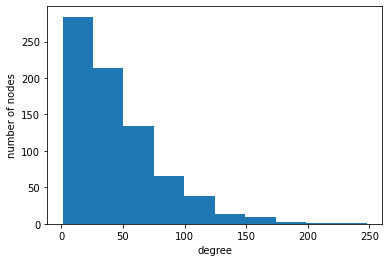

[662  94   6]


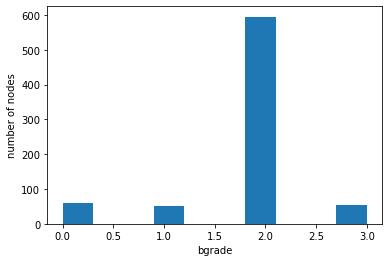

In [14]:
thirds={}
degrees={}
bthirds={}
_=vis_and_bin(facebook_caltech)
thirds['facebook']=_[0]
degrees['facebook']=_[1]
bthirds['facebook']=_[2]

In [15]:
bthirds

{'facebook': array([1.84645669, 3.        ])}

In [ ]:
for i in range(20):
    print(boxes.greedy_coloring(network=facebook_caltech,lb=2,boxing=True,strategy='random_sequential'))

In [ ]:
boxes.fuzzy(facebook_caltech,2,boxing=True)

In [ ]:
facebook_caltech.get_dist_dict

In [ ]:
facebook_caltech.diameter

In [ ]:
start=time.time()

facebook_caltech.get_dist_dict()

time_offset=time.time()-start

In [ ]:
time_offset

In [ ]:
help(boxes.io.run_boxing)

In [ ]:
gc.collect()

In [ ]:
os.mkdir('../../result_logs/facebook_caltech')
    

In [ ]:
logpath='../../result_logs/facebook_caltech/'
lb=range(1,7)
rb=range(1,7) # break statement in run_boxing
current_network=facebook_caltech
current_net='facebook_caltech'

In [ ]:
for algorithm in algs_lb.keys():
    
    random.seed(137)  #reproducibility
    np.random.seed(137)
    
    
    if algorithm!='merge':
        
        boxes.io.run_boxing({'path':logpath,'net':current_net,'alg':algorithm},
                           time_offset,
                            current_network,
                            lb,                         # box sizes
                           algs_lb[algorithm]['alg'],      # set algorithm
                           **algs_lb[algorithm]['kwargs']) # unpack keyword arguments
    else:
        
        current_network.shortest_paths=None # merge doesn't use distance dict - would give false overhead
        new_start=time.time()
        current_network.shortest_paths = dict(nx.all_pairs_shortest_path_length(current_network.graph))
        new_offset=time.time()-new_start
        
        boxes.io.run_boxing({'path':logpath,'net':current_net,'alg':algorithm},
                           new_offset,
                            current_network,
                            lb[-1],                         # box sizes - merge only needs max
                           algs_lb[algorithm]['alg'], # set algorithm
                            merge_alg=True,
                           **algs_lb[algorithm]['kwargs']) 
        
        
for algorithm in algs_rb.keys():
    if algorithm!='merge':
        boxes.io.run_boxing({'path':logpath,'net':current_net,'alg':algorithm},
                           time_offset,
                            current_network,
                            rb,                         # box sizes
                           algs_rb[algorithm]['alg'],      # set algorithm
                           **algs_rb[algorithm]['kwargs']) 

Benchmarking with greedy

In [ ]:
help(boxes.io.benchmark)

In [ ]:
boxes.io.benchmark(
{'path':logpath,'net':current_net,'alg':'greedy'},
                            current_network,
                            lb,                         # box sizes - merge only needs max
                           boxes.greedy_coloring, # set algorithm
                            50,
                           **algs_lb['greedy']['kwargs']
)

Extend with the hyperparameter tuning!

---

no simulated annealing: too many hyperparameters, silly internal energy

DE: only tune num_p, gen, F,CR fixed
 

In [ ]:
num_p=(10,20,40)
gen=20

for number in num_p:

    boxes.io.run_boxing({'path':logpath,'net':current_net,'alg':'differential_evolution_n_'+str(number)+'_g_'+str(gen)},
                               time_offset,
                                current_network,
                                lb,                         # box sizes
                               boxes.differential_evolution,      # set algorithm
                               **{'num_p':number,'gn':gen,'boxing':True,'dual_new':True})

nump=10 seems to be OK

In [16]:
del(facebook_caltech)
gc.collect()

26798

### Minnesota

In [17]:
minnesota=read_max_connected_component(path+'minnesota/road-minnesota.mtx',15)

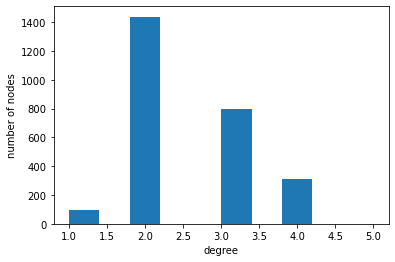

[1533  796  311]


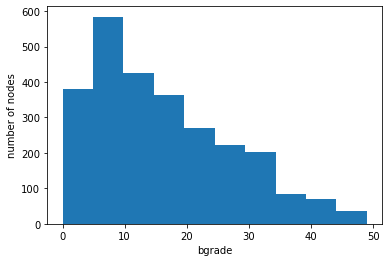

[16.01477273 49.        ]


In [19]:
_=vis_and_bin(minnesota)
thirds['minnesota']=_[0]
degrees['minnesota']=_[1]
bthirds['minnesota']=_[2]

In [ ]:
boxes.fuzzy(minnesota,2)

In [ ]:
boxes.greedy_coloring(minnesota,lb=2,boxing=True)

In [ ]:
minnesota.connected

In [ ]:
minnesota.diameter

In [ ]:
start=time.time()

minnesota.get_dist_dict()

time_offset=time.time()-start

In [ ]:
time_offset

In [ ]:
gc.collect()

In [ ]:
os.mkdir('../../result_logs/minnesota')

In [ ]:
logpath='../../result_logs/minnesota/'
lb=range(1,100,4)
rb=range(1,100,2) # break statement in run_boxing
current_network=minnesota
current_net='minnesota'

In [ ]:


for algorithm in algs_lb.keys():
    
    random.seed(137)  #reproducibility
    np.random.seed(137)
    
    
    if algorithm!='merge':
        
        boxes.io.run_boxing({'path':logpath,'net':current_net,'alg':algorithm},
                           time_offset,
                            current_network,
                            lb,                         # box sizes
                           algs_lb[algorithm]['alg'],      # set algorithm
                           **algs_lb[algorithm]['kwargs']) # unpack keyword arguments
    else:
        
        current_network.shortest_paths=None # merge doesn't use distance dict - would give false overhead
        gc.collect()
        
        new_start=time.time()
        current_network.shortest_paths = dict(nx.all_pairs_shortest_path_length(current_network.graph))
        new_offset=time.time()-new_start
        
        boxes.io.run_boxing({'path':logpath,'net':current_net,'alg':algorithm},
                           new_offset,
                            current_network,
                            lb[-1],                         # box sizes - merge only needs max
                           algs_lb[algorithm]['alg'], # set algorithm
                            merge_alg=True,
                           **algs_lb[algorithm]['kwargs']) 
        
        
for algorithm in algs_rb.keys():
    if algorithm!='merge':
        boxes.io.run_boxing({'path':logpath,'net':current_net,'alg':algorithm},
                           time_offset,
                            current_network,
                            rb,                         # box sizes
                           algs_rb[algorithm]['alg'],      # set algorithm
                           **algs_rb[algorithm]['kwargs']) 

DE manual

In [ ]:
num_p=(10,)
gen=20

for number in num_p:

    boxes.io.run_boxing({'path':logpath,'net':current_net,'alg':'differential_evolution_n_'+str(number)+'_g_'+str(gen)},
                               time_offset,
                                current_network,
                                lb,                         # box sizes
                               boxes.differential_evolution,      # set algorithm
                               **{'num_p':number,'gn':gen,'boxing':True,'dual_new':True})

In [ ]:
boxes.io.benchmark(
{'path':logpath,'net':current_net,'alg':'greedy'},
                            current_network,
                            lb,                         # box sizes - merge only needs max
                           boxes.greedy_coloring, # set algorithm
                            10,
                           **algs_lb['greedy']['kwargs']
)

In [20]:
del(minnesota)
gc.collect()

3343

### Grid graphs

In [ ]:
def boxing_for_algs(
logpath='../../result_logs/minnesota/',
lb=range(1,100,4),
rb=range(1,100,2), # break statement in run_boxing
current_network=None,
current_net='minnesota',
    time_offset=0,
    differential_evolution=True
):

    for algorithm in algs_lb.keys():

        random.seed(137)  #reproducibility
        np.random.seed(137)


        if algorithm!='merge':

            boxes.io.run_boxing({'path':logpath,'net':current_net,'alg':algorithm},
                               time_offset,
                                current_network,
                                lb,                         # box sizes
                               algs_lb[algorithm]['alg'],      # set algorithm
                               **algs_lb[algorithm]['kwargs']) # unpack keyword arguments
        else:

            current_network.shortest_paths=None # merge doesn't use distance dict - would give false overhead
            gc.collect()

            new_start=time.time()
            current_network.shortest_paths = dict(nx.all_pairs_shortest_path_length(current_network.graph))
            new_offset=time.time()-new_start

            boxes.io.run_boxing({'path':logpath,'net':current_net,'alg':algorithm},
                               new_offset,
                                current_network,
                                lb[-1],                         # box sizes - merge only needs max
                               algs_lb[algorithm]['alg'], # set algorithm
                                merge_alg=True,
                               **algs_lb[algorithm]['kwargs']) 


    for algorithm in algs_rb.keys():
        if algorithm!='merge':
            boxes.io.run_boxing({'path':logpath,'net':current_net,'alg':algorithm},
                               time_offset,
                                current_network,
                                rb,                         # box sizes
                               algs_rb[algorithm]['alg'],      # set algorithm
                               **algs_rb[algorithm]['kwargs']) 
    #DE
    
    if not differential_evolution:
        return 0
    
    number=10
    gen=20
    
    boxes.io.run_boxing({'path':logpath,'net':current_net,'alg':'differential_evolution_n_'+str(number)+'_g_'+str(gen)},
                               time_offset,
                                current_network,
                                lb,                         # box sizes
                               boxes.differential_evolution,      # set algorithm
                               **{'num_p':number,'gn':gen,'boxing':True,'dual_new':True})
    return 0

#### 2D

In [ ]:
os.mkdir('../../result_logs/grid2d')

In [ ]:
for size in [20,30,40,50,60]:

    network=boxes.network(nx.grid_graph(dim=(size,size)))
    
    start=time.time()

    network.get_dist_dict()

    time_offset=time.time()-start
    
    lb=np.logspace(0,np.log10(network.diameter),num=15,dtype=int)
    rb=np.logspace(0,np.log10(network.diameter),num=30,dtype=int)
    
    current_net='grid2d_'+str(size)
    
    os.mkdir('../../result_logs/grid2d/'+str(size))
    
    logpath='../../result_logs/grid2d/'+str(size)+'/'
    
    boxing_for_algs(
    logpath=logpath,
    lb=lb,
    rb=rb, # break statement in run_boxing
    current_network=network,
    current_net=current_net,
    time_offset=time_offset
    )
    
    del(network)
    gc.collect()
    
    
    
    


In [ ]:
for size in [20,30,40,50]:

    network=boxes.network(nx.grid_graph(dim=(size,size)))

    network.get_dist_dict()
    
    lb=np.logspace(0,np.log10(network.diameter),num=15,dtype=int)
    
    current_net='grid2d_'+str(size)
    
    logpath='../../result_logs/grid2d/'+str(size)+'/'
    
    boxes.io.benchmark(
{'path':logpath,'net':current_net,'alg':'greedy'},
                            network,
                            lb,                         # box sizes - merge only needs max
                           boxes.greedy_coloring, # set algorithm
                            10,
                           **algs_lb['greedy']['kwargs']
)
    
    del(network)
    gc.collect()
    
    
    
    


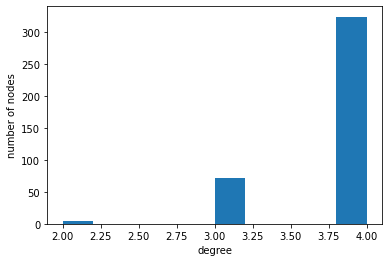

[  4  72 324]


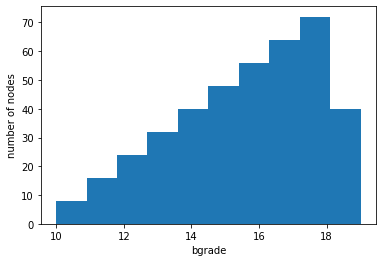

[15.7 19. ]


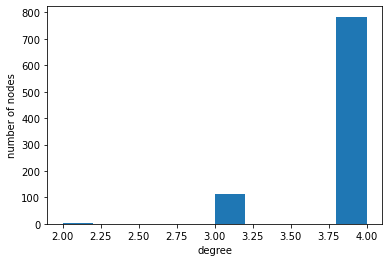

[  4 112 784]


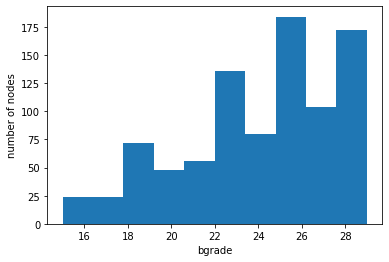

[24.02222222 29.        ]


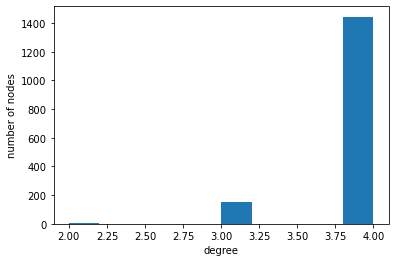

[   4  152 1444]


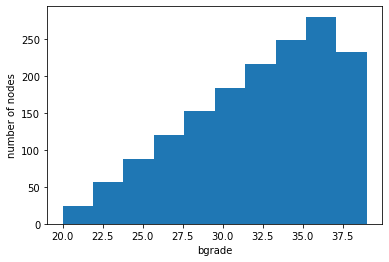

[32.35 39.  ]


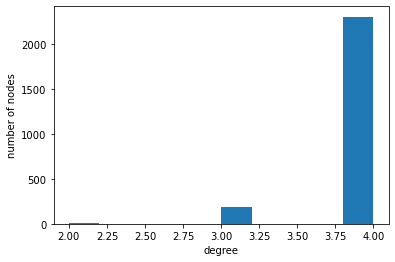

[   4  192 2304]


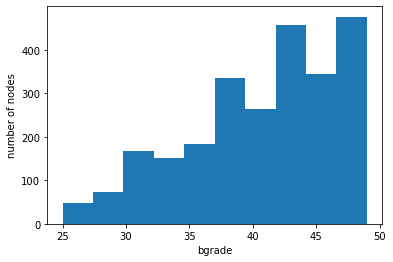

[40.68 49.  ]


In [21]:
for size in [20,30,40,50]:

    network=boxes.network(nx.grid_graph(dim=(size,size)))

    _=vis_and_bin(network)
    thirds['grid'+str(size)]=_[0]
    degrees['grid'+str(size)]=_[1]
    bthirds['grid'+str(size)]=_[2]
    
    del(network)
    gc.collect()
    
    
    
    


#### 3D

In [ ]:
os.mkdir('../../result_logs/grid3d')

In [ ]:
for size in [20,]:

    network=boxes.network(nx.grid_graph(dim=(size,size,size)))
    
    start=time.time()

    network.get_dist_dict()

    time_offset=time.time()-start
    
    lb=np.logspace(0,np.log10(network.diameter),num=15,dtype=int)
    rb=np.logspace(0,np.log10(network.diameter),num=30,dtype=int)
    
    current_net='grid3d_'+str(size)
    
    os.mkdir('../../result_logs/grid3d/'+str(size))
    
    logpath='../../result_logs/grid3d/'+str(size)+'/'
    
    boxing_for_algs(
    logpath=logpath,
    lb=lb,
    rb=rb, # break statement in run_boxing
    current_network=network,
    current_net=current_net,
    time_offset=time_offset
    )
    
    del(network)
    gc.collect()
    
    
    
    


In [22]:
gc.collect()

20

#### UV flower

Based on previous calculations, we try 3 nets:

+ u,v=1,2 (non-fractal)
+ u,v=2,2 fractal, theoretical db: 2
+ u,v=2,4 fractal, theoretical db: 2.6

__UV_12, gen=7__

In [ ]:
help(boxes.generators.uv_flower)

In [29]:
del(network)

In [30]:
gc.collect()

6701

In [ ]:
os.mkdir('../../result_logs/uv_12_g7')

In [23]:
network=boxes.network(boxes.generators.uv_flower(1,2,7))

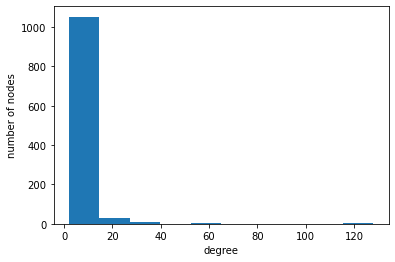

[1089    3    3]


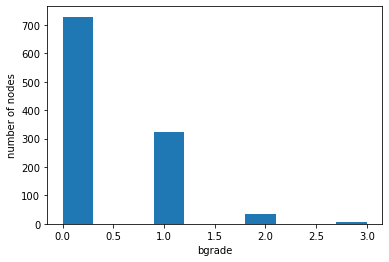

[0.37808219 3.        ]


In [24]:
 _=vis_and_bin(network)
thirds['uv127']=_[0]
degrees['uv127']=_[1]
bthirds['uv127']=_[2]

In [ ]:
network.distance_dict.keys()

In [ ]:
start=time.time()

network.get_dist_dict()

time_offset=time.time()-start

lb=range(1,8)
rb=range(1,8)

current_net='uv_12_g7'

logpath='../../result_logs/uv_12_g7/'

boxing_for_algs(
logpath=logpath,
lb=lb,
rb=rb, # break statement in run_boxing
current_network=network,
current_net=current_net,
time_offset=time_offset
)

del(network)
gc.collect()

In [ ]:
start=time.time()

network.get_dist_dict()

time_offset=time.time()-start

lb=range(1,8)

current_net='uv_12_g7'

logpath='../../result_logs/uv_12_g7/'


boxes.io.benchmark(
{'path':logpath,'net':current_net,'alg':'greedy'},
                            network,
                            lb,                         # box sizes - merge only needs max
                           boxes.greedy_coloring, # set algorithm
                            10,
                           **algs_lb['greedy']['kwargs'])

__UV_22, gen=5__

In [27]:
network=boxes.network(boxes.generators.uv_flower(2,2,5))

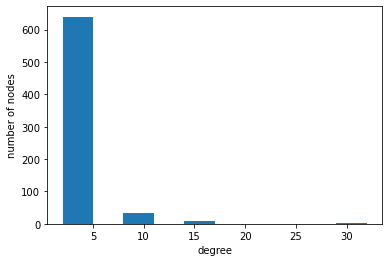

[672   8   4]


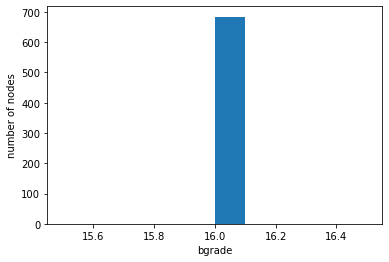

[16. 16.]


In [28]:
 _=vis_and_bin(network)
thirds['uv225']=_[0]
degrees['uv225']=_[1]
bthirds['uv225']=_[2]

In [ ]:
os.mkdir('../../result_logs/uv_22_g5')

In [ ]:
network.diameter

In [ ]:
start=time.time()

network.get_dist_dict()

time_offset=time.time()-start

lb=range(1,32,2)
rb=range(1,30)

current_net='uv_22_g5'

logpath='../../result_logs/uv_22_g5/'

boxing_for_algs(
logpath=logpath,
lb=lb,
rb=rb, # break statement in run_boxing
current_network=network,
current_net=current_net,
time_offset=time_offset
)

del(network)
gc.collect()

In [ ]:
start=time.time()

network.get_dist_dict()

time_offset=time.time()-start

lb=range(1,32,2)

current_net='uv_22_g5'

logpath='../../result_logs/uv_22_g5/'


boxes.io.benchmark(
{'path':logpath,'net':current_net,'alg':'greedy'},
                            network,
                            lb,                         # box sizes - merge only needs max
                           boxes.greedy_coloring, # set algorithm
                            10,
                           **algs_lb['greedy']['kwargs'])

__UV_24, gen=4__

In [31]:
network=boxes.network(boxes.generators.uv_flower(2,4,4))

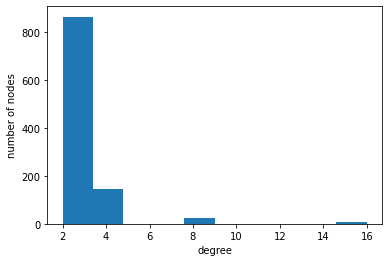

[1008   24    6]


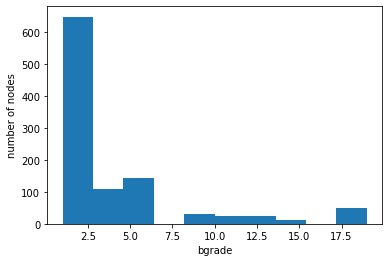

[ 4.05202312 19.        ]


In [32]:
 _=vis_and_bin(network)
thirds['uv244']=_[0]
degrees['uv244']=_[1]
bthirds['uv244']=_[2]
del(network)
gc.collect()

In [ ]:
os.mkdir('../../result_logs/uv_24_g4')

In [33]:
del(network)
gc.collect()

6733

In [ ]:
start=time.time()

network.get_dist_dict()

time_offset=time.time()-start

lb=range(1,38,2)
rb=range(1,38)

current_net='uv_24_g4'

logpath='../../result_logs/uv_24_g4/'

boxing_for_algs(
logpath=logpath,
lb=lb,
rb=rb, # break statement in run_boxing
current_network=network,
current_net=current_net,
time_offset=time_offset
)

del(network)
gc.collect()

In [ ]:
start=time.time()

network.get_dist_dict()

time_offset=time.time()-start

lb=range(1,38,2)

current_net='uv_24_g4'

logpath='../../result_logs/uv_24_g4/'


boxes.io.benchmark(
{'path':logpath,'net':current_net,'alg':'greedy'},
                            network,
                            lb,                         # box sizes - merge only needs max
                           boxes.greedy_coloring, # set algorithm
                            10,
                           **algs_lb['greedy']['kwargs'])

#### SHM model

__SHM_gmxe_5210__

In [ ]:
help(boxes.generators.fractal_model)

In [34]:
network=boxes.network(boxes.generators.fractal_model(5,2,1,0.))

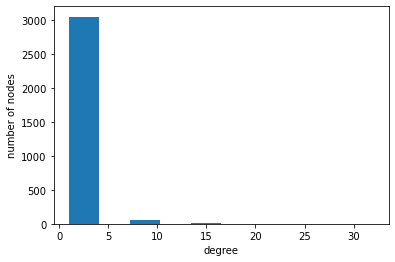

[3110   12    4]


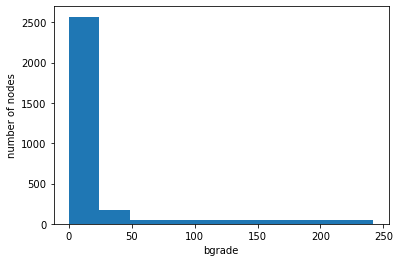

[ 22.19001919 242.        ]


3261

In [35]:
 _=vis_and_bin(network)
thirds['shm5210']=_[0]
degrees['shm5210']=_[1]
bthirds['shm5210']=_[2]
del(network)
gc.collect()

In [ ]:
os.mkdir('../../result_logs/shm_gmxe_5210')

In [ ]:
network.diameter

In [ ]:
start=time.time()

network.get_dist_dict()

time_offset=time.time()-start

lb=np.logspace(0,np.log10(network.diameter),num=15,dtype=int)
rb=np.logspace(0,np.log10(network.diameter),num=30,dtype=int)

current_net='shm_gmxe_5210'

logpath='../../result_logs/shm_gmxe_5210/'

boxing_for_algs(
logpath=logpath,
lb=lb,
rb=rb, # break statement in run_boxing
current_network=network,
current_net=current_net,
time_offset=time_offset
)

del(network)
gc.collect()

In [ ]:
start=time.time()

network.get_dist_dict()

time_offset=time.time()-start

lb=np.logspace(0,np.log10(network.diameter),num=15,dtype=int)

current_net='shm_gmxe_5210'

logpath='../../result_logs/shm_gmxe_5210/'


boxes.io.benchmark(
{'path':logpath,'net':current_net,'alg':'greedy'},
                            network,
                            lb,                         # box sizes - merge only needs max
                           boxes.greedy_coloring, # set algorithm
                            10,
                           **algs_lb['greedy']['kwargs'])

__SHM_gmxe_422_0.__

In [36]:
network=boxes.network(boxes.generators.fractal_model(4,2,2,0.))

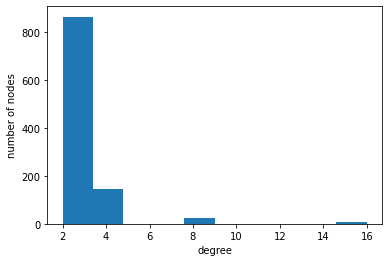

[1008   24    6]


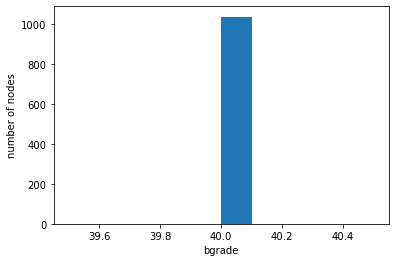

[40. 40.]


3199

In [37]:
 _=vis_and_bin(network)
thirds['shm4220']=_[0]
degrees['shm4220']=_[1]
bthirds['shm4220']=_[2]
del(network)
gc.collect()

In [ ]:
os.mkdir('../../result_logs/shm_gmxe_4220')

In [ ]:
network.diameter

In [ ]:
start=time.time()

network.get_dist_dict()

time_offset=time.time()-start

lb=np.logspace(0,np.log10(network.diameter),num=15,dtype=int)
rb=np.logspace(0,np.log10(network.diameter),num=30,dtype=int)

current_net='shm_gmxe_4220'

logpath='../../result_logs/shm_gmxe_4220/'

boxing_for_algs(
logpath=logpath,
lb=lb,
rb=rb, # break statement in run_boxing
current_network=network,
current_net=current_net,
time_offset=time_offset,
    differential_evolution=False
)

del(network)
gc.collect()

In [ ]:
start=time.time()

network.get_dist_dict()

time_offset=time.time()-start

lb=np.logspace(0,np.log10(network.diameter),num=15,dtype=int)

current_net='shm_gmxe_4220'

logpath='../../result_logs/shm_gmxe_4220/'


boxes.io.benchmark(
{'path':logpath,'net':current_net,'alg':'greedy'},
                            network,
                            lb,                         # box sizes - merge only needs max
                           boxes.greedy_coloring, # set algorithm
                            10,
                           **algs_lb['greedy']['kwargs'])

__SHM_gmxe_521_0.5__

In [38]:
network=boxes.network(boxes.generators.fractal_model(5,2,1,0.5))

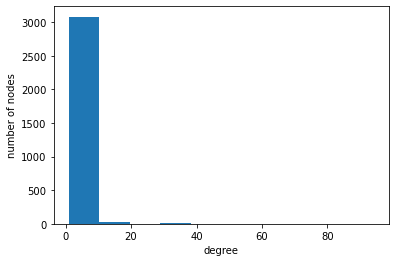

[3116    7    3]


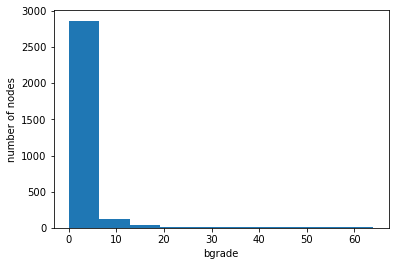

[ 2.5003199 64.       ]


3385

In [39]:
 _=vis_and_bin(network)
thirds['shm521_0.5']=_[0]
degrees['shm521_0.5']=_[1]
bthirds['shm521_0.5']=_[2]
del(network)
gc.collect()

In [ ]:
os.mkdir('../../result_logs/shm_gmxe_521_0.5_distribution')

network.diameter

In [ ]:
lb=[2,4]
rb=[1,2]

current_net='shm_gmxe_521_0.5'

logpath='../../result_logs/shm_gmxe_521_0.5_distribution/'

# for algorithm in ['merge']:

#         random.seed(137)  #reproducibility
#         np.random.seed(137)

#         boxes.io.benchmark({'path':logpath,'net':current_net,'alg':algorithm},
#                             network,
#                             lb,                         # box sizes
#                            algs_lb[algorithm]['alg'],# set algorithm
#                            40,
#                            **algs_lb[algorithm]['kwargs']) # unpack keyword argument


for algorithm in algs_rb.keys():
    if algorithm!='merge':
        boxes.io.benchmark({'path':logpath,'net':current_net,'alg':algorithm},
                            network,
                            rb,                         # box sizes
                           algs_rb[algorithm]['alg'],# set algorithm
                            40,
                           **algs_rb[algorithm]['kwargs']) 

In [ ]:
start=time.time()

network.get_dist_dict()

time_offset=time.time()-start

lb=np.logspace(0,np.log10(network.diameter),num=15,dtype=int)
rb=np.logspace(0,np.log10(network.diameter),num=30,dtype=int)

current_net='shm_gmxe_521_0.5'

logpath='../../result_logs/shm_gmxe_521_0.5/'

boxing_for_algs(
logpath=logpath,
lb=lb,
rb=rb, # break statement in run_boxing
current_network=network,
current_net=current_net,
time_offset=time_offset,
    differential_evolution=False
)

del(network)
gc.collect()

In [ ]:
start=time.time()

network.get_dist_dict()

time_offset=time.time()-start

lb=np.logspace(0,np.log10(network.diameter),num=15,dtype=int)

current_net='shm_gmxe_521_0.5'

logpath='../../result_logs/shm_gmxe_521_0.5/'


boxes.io.benchmark(
{'path':logpath,'net':current_net,'alg':'greedy'},
                            network,
                            lb,                         # box sizes - merge only needs max
                           boxes.greedy_coloring, # set algorithm
                            10,
                           **algs_lb['greedy']['kwargs'])

In [ ]:
def high_level_boxing(network,crnt_net):
    
    os.mkdir('../../result_logs/'+crnt_net)
    
    start=time.time()

    network.get_dist_dict()

    time_offset=time.time()-start

    lb=np.logspace(0,np.log10(network.diameter),num=15,dtype=int)
    rb=np.logspace(0,np.log10(network.diameter),num=30,dtype=int)

    boxing_for_algs(
    logpath='../../result_logs/'+crnt_net+'/',
    lb=lb,
    rb=rb, # break statement in run_boxing
    current_network=network,
    current_net=crnt_net,
    time_offset=time_offset,
    differential_evolution=False
    )

    del(network)
    gc.collect()

__SHM_gmxe_422_0.5__

In [40]:
network=boxes.network(boxes.generators.fractal_model(4,2,2,0.5))

network.diameter

35

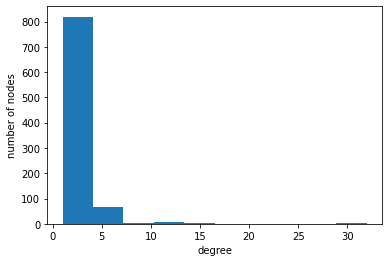

[893   7   6]


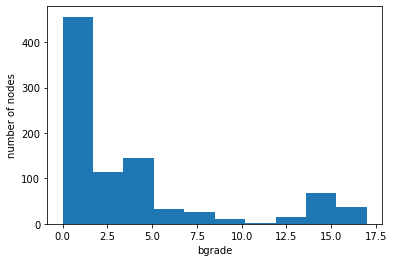

[ 3.65783664 17.        ]


6847

In [41]:
 _=vis_and_bin(network)
thirds['shm442_0.5']=_[0]
degrees['shm442_0.5']=_[1]
bthirds['shm442_0.5']=_[2]
del(network)
gc.collect()

In [ ]:
start=time.time()

network.get_dist_dict()

time_offset=time.time()-start

lb=np.logspace(0,np.log10(network.diameter),num=15,dtype=int)

current_net='shm_gmxe_422_0.5'

logpath='../../result_logs/shm_gmxe_422_0.5/'


boxes.io.benchmark(
{'path':logpath,'net':current_net,'alg':'greedy'},
                            network,
                            lb,                         # box sizes - merge only needs max
                           boxes.greedy_coloring, # set algorithm
                            10,
                           **algs_lb['greedy']['kwargs'])

In [ ]:
high_level_boxing(network,'shm_gmxe_422_0.5')

__SHM_gmxe_521_1__

In [42]:
network=boxes.network(boxes.generators.fractal_model(5,2,1,1))

network.diameter

11

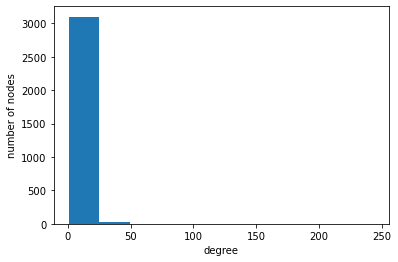

[3120    4    2]


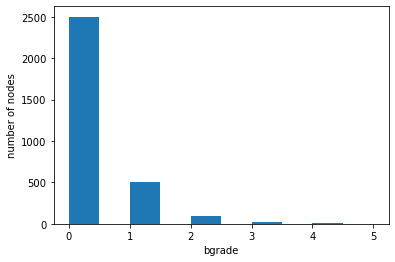

[0.25143954 5.        ]


6584

In [43]:
 _=vis_and_bin(network)
thirds['shm5211']=_[0]
degrees['shm5211']=_[1]
bthirds['shm5211']=_[2]
del(network)
gc.collect()

In [ ]:
os.mkdir('../../result_logs/shm_gmxe_521_1')

start=time.time()

network.get_dist_dict()

time_offset=time.time()-start

lb=range(1,12)
rb=range(1,12)

current_net='shm_gmxe_521_1'

logpath='../../result_logs/shm_gmxe_521_1/'

boxing_for_algs(
logpath=logpath,
lb=lb,
rb=rb, # break statement in run_boxing
current_network=network,
current_net=current_net,
time_offset=time_offset,
    differential_evolution=False
)

del(network)
gc.collect()

In [ ]:
network.get_dist_dict()

lb=range(1,12)

current_net='shm_gmxe_521_1'

logpath='../../result_logs/shm_gmxe_521_1/'


boxes.io.benchmark(
{'path':logpath,'net':current_net,'alg':'greedy'},
                            network,
                            lb,                         # box sizes - merge only needs max
                           boxes.greedy_coloring, # set algorithm
                            10,
                           **algs_lb['greedy']['kwargs'])

#### HADGM

In [ ]:
help(boxes.generators.hub_attraction_dynamical_growth_model)

__HADGM_gmabt_421_0.5_0.5__

In [ ]:
gc.collect()

In [44]:
network=boxes.network(boxes.generators.hub_attraction_dynamical_growth_model(4,2,1,0.5,0.5))

network.diameter

20

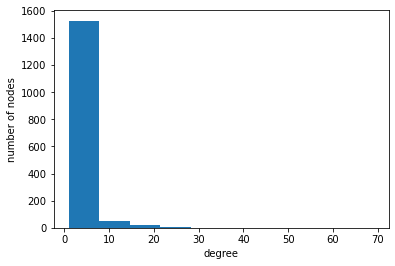

[1590   10    2]


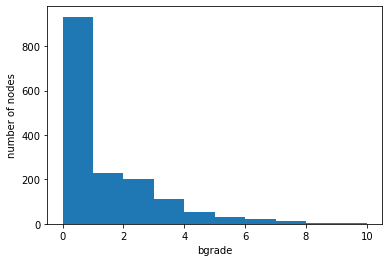

[ 1.01248439 10.        ]


6770

In [45]:
 _=vis_and_bin(network)
thirds['hadgm421_0.5_0.5']=_[0]
degrees['hadgm421_0.5_0.5']=_[1]
bthirds['hadgm421_0.5_0.5']=_[2]
del(network)
gc.collect()

In [ ]:
start=time.time()

network.get_dist_dict()

time_offset=time.time()-start

lb=np.logspace(0,np.log10(network.diameter),num=15,dtype=int)

current_net='hadgm_gmabt_421_0.5_0.5'

logpath='../../result_logs/hadgm_gmabt_421_0.5_0.5/'


boxes.io.benchmark(
{'path':logpath,'net':current_net,'alg':'greedy'},
                            network,
                            lb,                         # box sizes - merge only needs max
                           boxes.greedy_coloring, # set algorithm
                            10,
                           **algs_lb['greedy']['kwargs'])

In [ ]:
high_level_boxing(network,'hadgm_gmabt_421_0.5_0.5')


__HADGM_gmabt_421_1_0.5__

In [46]:
network=boxes.network(boxes.generators.hub_attraction_dynamical_growth_model(4,2,1,1,0.5))

network.diameter

9

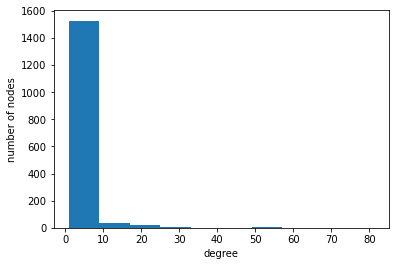

[1590   10    2]


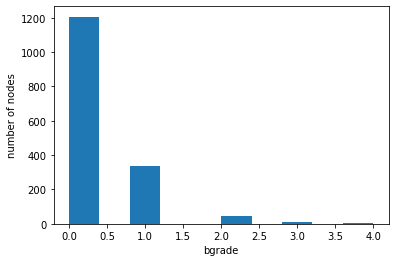

[0.29338327 4.        ]


7142

In [47]:
 _=vis_and_bin(network)
thirds['hadgm421_1_0.5']=_[0]
degrees['hadgm421_1_0.5']=_[1]
bthirds['hadgm421_1_0.5']=_[2]
del(network)
gc.collect()

In [ ]:

network.get_dist_dict()

os.mkdir('../../result_logs/hadgm_gmabt_421_1_0.5_distribution/')

In [ ]:
lb=[2,4]
rb=[1,2]

current_net='hadgm_gmabt_421_1_0.5'

logpath='../../result_logs/hadgm_gmabt_421_1_0.5_distribution/'

for algorithm in algs_lb.keys():

        random.seed(137)  #reproducibility
        np.random.seed(137)

        boxes.io.benchmark({'path':logpath,'net':current_net,'alg':algorithm},
                            network,
                            lb,                         # box sizes
                           algs_lb[algorithm]['alg'],# set algorithm
                           50,
                           **algs_lb[algorithm]['kwargs']) # unpack keyword argument


for algorithm in algs_rb.keys():
    if algorithm!='merge':
        boxes.io.run_boxing({'path':logpath,'net':current_net,'alg':algorithm},
                            network,
                            rb,                         # box sizes
                           algs_rb[algorithm]['alg'],# set algorithm
                            50,
                           **algs_rb[algorithm]['kwargs']) 

In [ ]:
high_level_boxing(network,'hadgm_gmabt_421_1_0.5')

### Enzyme network

In [48]:
enzyme=read_max_connected_component(path+'ENZYMES_g296/ENZYMES_g296.edges',0)
print(enzyme.connected)
print(enzyme.diameter)

True
32


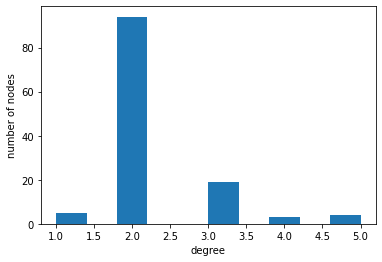

[99 19  7]


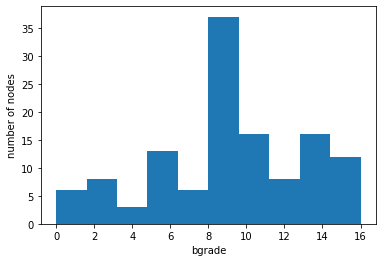

[ 8.952 16.   ]


NameError: name 'network' is not defined

In [50]:
 _=vis_and_bin(enzyme)
thirds['enzyme']=_[0]
degrees['enzyme']=_[1]
bthirds['enzyme']=_[2]
del(network)
gc.collect()

In [51]:
del(enzyme)
gc.collect()

6992

In [ ]:
os.mkdir('../../result_logs/enzyme')

network=enzyme

start=time.time()

network.get_dist_dict()

time_offset=time.time()-start

lb=range(1,32,2)
rb=range(1,30)

current_net='enzyme'

logpath='../../result_logs/enzyme/'

boxing_for_algs(
logpath=logpath,
lb=lb,
rb=rb, # break statement in run_boxing
current_network=network,
current_net=current_net,
time_offset=time_offset,
    differential_evolution=False
)

del(network)
gc.collect()

In [ ]:
enzyme.get_dist_dict()

lb=range(1,32,2)

current_net='enzyme'

logpath='../../result_logs/enzyme/'


boxes.io.benchmark(
{'path':logpath,'net':current_net,'alg':'greedy'},
                            enzyme,
                            lb,                         # box sizes - merge only needs max
                           boxes.greedy_coloring, # set algorithm
                            10,
                           **algs_lb['greedy']['kwargs'])

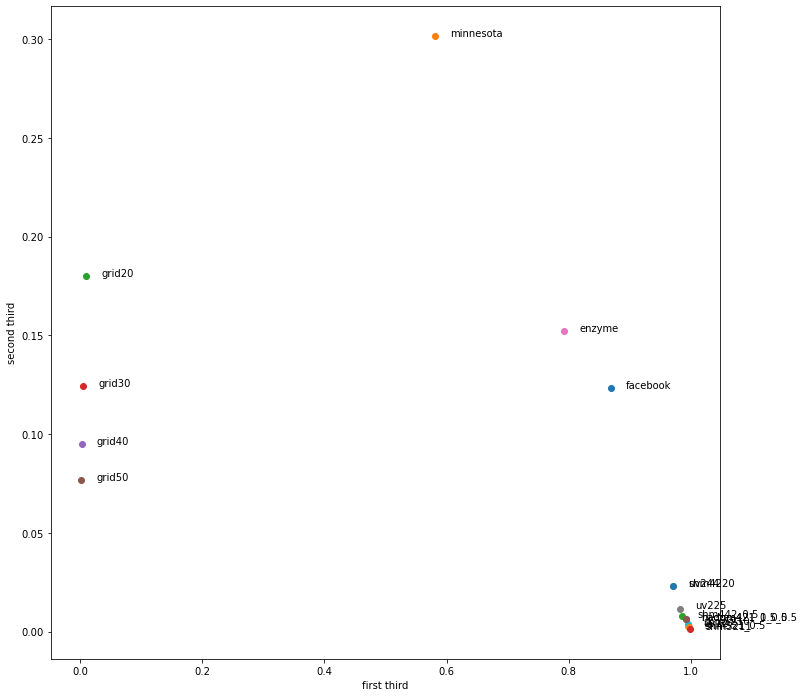

In [58]:
plt.figure(figsize=(12,12))
for key, value in thirds.items():
    plt.scatter(value[0]/np.sum(value),value[1]/np.sum(value),label=key)
    plt.text(value[0]/np.sum(value)+0.025,value[1]/np.sum(value),key)
plt.xlabel('first third')
plt.ylabel('second third')
# plt.legend()
plt.show()

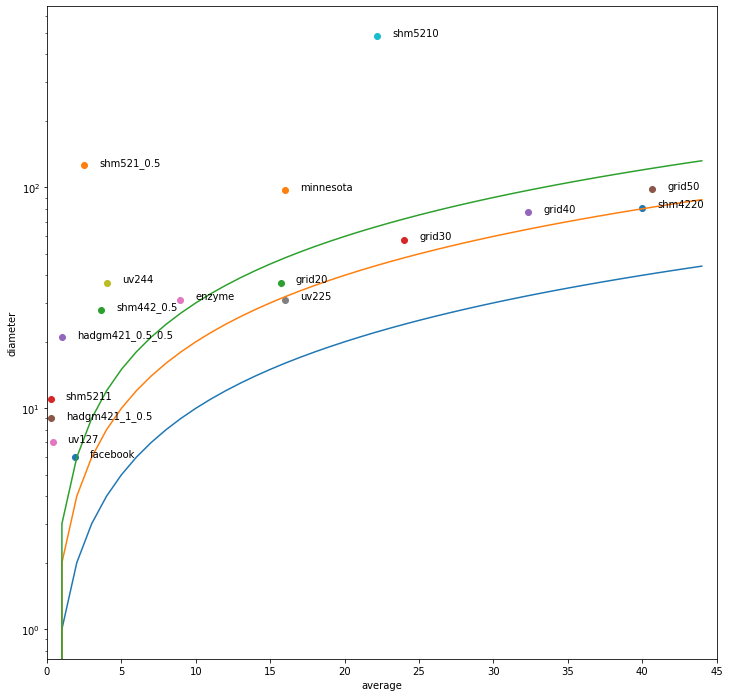

In [84]:
plt.figure(figsize=(12,12))
for key, value in bthirds.items():
    plt.scatter(value[0],int(approx_diameter[key]),label=key)
    plt.text(value[0]+1,int(approx_diameter[key]),key)
    
plt.plot(range(45),range(45))
plt.plot(range(45),range(0,89,2))
plt.plot(range(45),range(0,44*3+1,3))

plt.xlabel('average')
plt.ylabel('diameter')
plt.xlim(0,45)
plt.yscale('log')
# plt.legend()
plt.show()

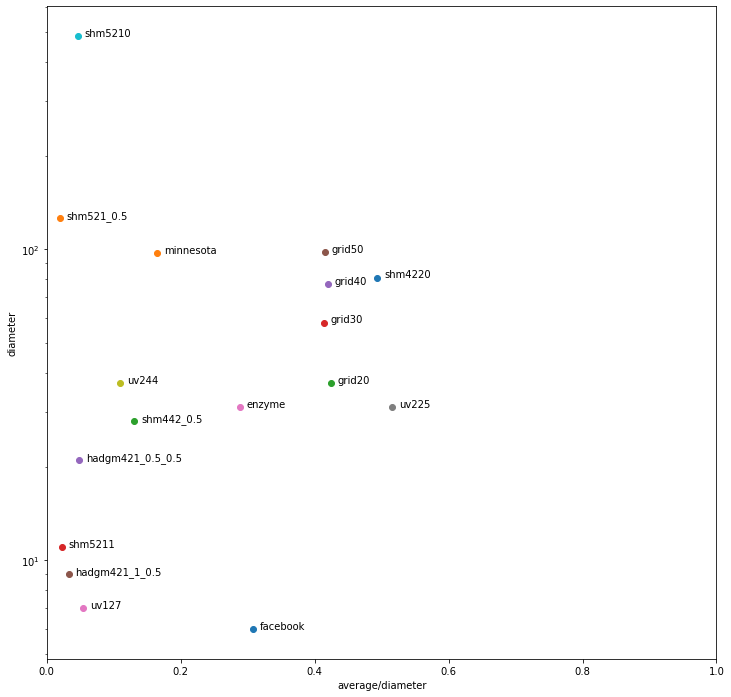

In [85]:
plt.figure(figsize=(12,12))
for key, value in bthirds.items():
    plt.scatter(value[0]/int(approx_diameter[key]),int(approx_diameter[key]),label=key)
    plt.text(value[0]/int(approx_diameter[key])+0.01,int(approx_diameter[key]),key)
    
# plt.plot(range(45),range(45))
# plt.plot(range(45),range(0,89,2))
# plt.plot(range(45),range(0,44*3+1,3))

plt.xlabel('average/diameter')
plt.ylabel('diameter')
plt.xlim(0,1)
plt.yscale('log')
# plt.legend()
plt.show()

Text(9.952, 31, 'enzyme')

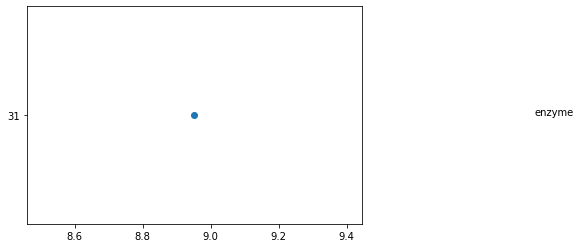

In [67]:
key='enzyme'
plt.scatter(value[0],approx_diameter[key],label=key)
plt.text(value[0]+1,approx_diameter[key],key)